# Attention for seq2seq

This notebook has been adapted fom the pytorch tutorial [NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) by Sean Robertson and adapted by Marc Lelarge for the [deep learning course](https://dataflowr.github.io/website/)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# where data is stored:
# if on COLAB, you can comment the following lines 
import os
from pathlib import Path

ROOT_DIR = Path.home()
data_path = os.path.join(ROOT_DIR,'data/')

# and uncomment the following lines if on COLAB, you can download the data with:
#!wget https://download.pytorch.org/tutorial/data.zip
#!unzip data.zip
#data_path = './'

In [3]:
def running_mean(x, N=100):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# data preprocessing

This code is directly taken from the Pytorch tutorial and creates the corpus of pairs of sentences in french and english as well as the french and englsih tokenizers.

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(data_path+'data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPair_test(p):
    return len(p[0].split(' ')) > MAX_LENGTH and \
        len(p[1].split(' ')) > MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def filterPairs_test(pairs):
    return [pair for pair in pairs if filterPair_test(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['il est tres prudent .', 'he is very careful .']


In [5]:
pairs_train, pairs_val = train_test_split(pairs, test_size=0.2, random_state=42)

In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [7]:
val_pairs = [tensorsFromPair(pv) for pv in pairs_val]

# Seq2seq

Here we follow the PyTorch tutorial and implement [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215v3). The only modification in the code is that the encoder takes a full sentence (and no hidden state) in the forward pass and outputs all the correponding hidden states. As a result, there is no need to make a for loop for the encoder. Still, to get things simple, we do not deal with batches, if you want to deal with batches have a look at [Batches with sequences in Pytorch](https://dataflowr.github.io/website/modules/11c-batches-with-sequences/).

We also train on a test set and compute the loss on a validation set (see the split done on the corpus above).

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input):
        embedded = self.embedding(input)
        output, _ = self.gru(embedded, self.initHidden())
        return output

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
n_iters = 4
training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

In [10]:
training_pairs[0][0]

tensor([[   6],
        [  11],
        [ 365],
        [ 902],
        [ 210],
        [ 248],
        [2330],
        [1366],
        [   5],
        [   1]], device='cuda:0')

In [11]:
training_pairs[0][1]

tensor([[  2],
        [  3],
        [ 26],
        [129],
        [727],
        [483],
        [  4],
        [  1]], device='cuda:0')

In [12]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

In [13]:
one_input = training_pairs[0][0]
out = encoder(one_input)
# here is the code used in the tutorial:
#encoder_hidden = encoder.initHidden()
#for c in one_input:
#    out, encoder_hidden = encoder(c,encoder_hidden)

In [14]:
out.shape

torch.Size([10, 1, 256])

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

In [17]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = out[-1,:,:].view(1,1,hidden_size)

In [18]:
decoder_hidden.shape

torch.Size([1, 1, 256])

In [19]:
output, hidden = decoder(decoder_input, decoder_hidden)

In [20]:
def train_onepair(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio = 0.5):
    encoder_hidden = encoder.initHidden()
    
    encoder = encoder.train()
    decoder = decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    target_length = target_tensor.size(0)
    loss = 0
    encoder_outputs = encoder(input_tensor)
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_outputs[-1,:,:].view(1,1,hidden_size)
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
def eval_onepair(input_tensor, target_tensor, encoder, decoder, criterion, teacher_forcing_ratio = 0.5):
    encoder_hidden = encoder.initHidden()

    encoder = encoder.eval()
    decoder = decoder.eval()
    target_length = target_tensor.size(0)
    loss = 0
    encoder_outputs = encoder(input_tensor)
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_outputs[-1,:,:].view(1,1,hidden_size)
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss.item() / target_length

In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, learning_rate=0.01, teacher_forcing_ratio=0.9):
    
    plot_losses = []
    plot_losses_val = []
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs_train))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_onepair(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio)
        print_loss_total += loss
        plot_losses.append(loss)

        if iter % print_every == 0:
            loss_val = 0
            for (input_tensor, target_tensor) in val_pairs:
                loss = eval_onepair(input_tensor, target_tensor, encoder,
                     decoder, criterion, teacher_forcing_ratio)
                loss_val += loss
            loss_val = loss_val/len(val_pairs)
            plot_losses_val.append(loss_val)
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) loss train %.4f and val %.4f' % (iter, iter / n_iters * 100, print_loss_avg, loss_val))
    return plot_losses, plot_losses_val

In [23]:
learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
train_onepair(training_pairs[0][0],training_pairs[0][1],encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)

7.963138580322266

In [ ]:
hidden_size = 128
n_epochs = 50000
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
plot_losses,plot_losses_val = trainIters(encoder,decoder,n_epochs,print_every=2500)

In [ ]:
plt.plot(running_mean(plot_losses))
plt.plot([2500*i for i in range(int(n_epochs/2500))], plot_losses_val)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = encoder(input_tensor)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_outputs[-1,:,:].view(1,1,hidden_size)

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_val)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder, decoder)

# Attention mechanism

Here we implement the attention mechanism from the paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). The code below is siginficantly different from the original Pytorch Tutorial...

In [24]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size, padding_idx=0)
        self.attn_w = nn.Linear(2 * self.hidden_size, self.hidden_size)
        self.attn_v = nn.Linear(self.hidden_size, 1)
        self.gru = nn.GRU(self.hidden_size * 2, self.hidden_size)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # B = 1 batch size
        # encoder_outputs (L,B,H)
        seq_len, _, _ = encoder_outputs.shape
        # hidden (1,B,H)
        hidden_tile = hidden.repeat(seq_len, 1, 1) # (L,B,H)
        concat = torch.cat((hidden_tile, encoder_outputs), dim=2) # (L,B,2*H)
        attn_weights = F.softmax(self.attn_v(torch.tanh(self.attn_w(concat))), dim=0)
        # attn_weights (L,B,1) torch.sum(attn_weights,dim=0) = 1
        contexts = torch.einsum('jbi,jbk->ibk', attn_weights, encoder_outputs) # (1,B,H)
        # input is previous predicition 
        embedded = self.embedding(input).view(1,1,-1) # (1,B,H)
        output = torch.cat((embedded, contexts), 2) # (1,B,2*H)
        output, hidden = self.gru(output, hidden)
        # output (1,B,H)
        output = F.log_softmax(self.out(torch.cat((output[0], contexts[0]), 1)),dim=1) # (B,O)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
one_input = training_pairs[0][0]
out = encoder(one_input)

In [26]:
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

In [27]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_hidden = decoder.initHidden()
encoder_outputs = out

In [28]:
decoder_input.shape

torch.Size([1, 1])

In [29]:
output, hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)

In [30]:
attn_weights.shape

torch.Size([10, 1, 1])

In [31]:
torch.sum(attn_weights,dim=0)

tensor([[1.0000]], device='cuda:0', grad_fn=<SumBackward1>)

In [32]:
def train_onepair(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio = 0.5):
    encoder_hidden = encoder.initHidden()
    
    encoder = encoder.train()
    decoder = decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    target_length = target_tensor.size(0)
    loss = 0
    encoder_outputs = encoder(input_tensor)
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = decoder.initHidden()
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [33]:
def eval_onepair(input_tensor, target_tensor, encoder, decoder, criterion, teacher_forcing_ratio = 0.5):
    encoder_hidden = encoder.initHidden()

    encoder = encoder.eval()
    decoder = decoder.eval()
    target_length = target_tensor.size(0)
    loss = 0
    encoder_outputs = encoder(input_tensor)
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = decoder.initHidden()
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss.item() / target_length

In [34]:
learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
train_onepair(training_pairs[0][0],training_pairs[0][1],encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)

7.947208404541016

In [35]:
hidden_size = 128
n_epochs = 50000
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
plot_losses,plot_losses_val = trainIters(encoder,decoder,n_epochs,print_every=2500)

(2500 5%) loss train 3.0568 and val 2.5541
(5000 10%) loss train 2.4029 and val 2.2635
(7500 15%) loss train 2.0535 and val 2.0427
(10000 20%) loss train 1.8902 and val 1.9650
(12500 25%) loss train 1.6927 and val 1.7978
(15000 30%) loss train 1.5198 and val 1.7053
(17500 35%) loss train 1.4273 and val 1.6272
(20000 40%) loss train 1.3056 and val 1.5963
(22500 45%) loss train 1.2387 and val 1.4895
(25000 50%) loss train 1.1219 and val 1.4508
(27500 55%) loss train 1.0283 and val 1.4264
(30000 60%) loss train 0.9467 and val 1.4197
(32500 65%) loss train 0.8894 and val 1.3710
(35000 70%) loss train 0.8265 and val 1.3542
(37500 75%) loss train 0.8038 and val 1.3424
(40000 80%) loss train 0.7483 and val 1.3240
(42500 85%) loss train 0.7081 and val 1.3074
(45000 90%) loss train 0.6328 and val 1.2790
(47500 95%) loss train 0.6097 and val 1.2753
(50000 100%) loss train 0.5575 and val 1.2652


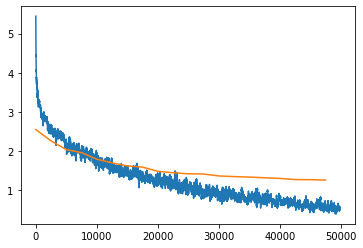

In [36]:
plt.plot(running_mean(plot_losses))
plt.plot([2500*i for i in range(int(n_epochs/2500))], plot_losses_val)

In [37]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = encoder(input_tensor)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = decoder.initHidden()

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di,:input_length] = decoder_attention[:,0,0].data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1,:input_length]

In [38]:
francais = "c est un jeune directeur plein de talent ."#"elle a cinq ans de moins que moi ."
output_words, attentions = evaluate(encoder, decoder, francais)

In [39]:
attentions.shape

torch.Size([9, 10])

In [40]:
torch.sum(attentions,dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

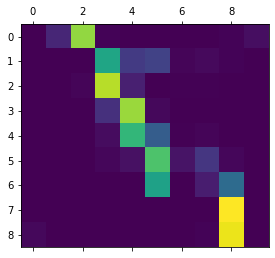

In [41]:
plt.matshow(attentions.numpy())

In [42]:
indexesFromSentence(input_lang, francais)

[145, 25, 66, 224, 3766, 240, 101, 969, 5]

In [43]:
tensorFromSentence(input_lang, francais)

tensor([[ 145],
        [  25],
        [  66],
        [ 224],
        [3766],
        [ 240],
        [ 101],
        [ 969],
        [   5],
        [   1]], device='cuda:0')

In [44]:
output_words

['he', 'is', 'a', 'very', 'sensitive', 'to', 'cold', '.', '<EOS>']

In [45]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_val)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [46]:
evaluateRandomly(encoder, decoder)

> il a peur de devenir malade .
= he is afraid of becoming sick .
< he is afraid of heights . <EOS>

> je ne suis pas occupe aujourd hui .
= i m not busy today .
< i m not busy today . <EOS>

> tu es fort effrontee .
= you re very forward .
< you re very forward . <EOS>

> c est un emmerdeur .
= he is a tough cookie .
< he is a methodical . <EOS>

> nous avons toujours raison .
= we re always right .
< we re always right . <EOS>

> je suis creve .
= i am tired .
< i am exhausted . <EOS>

> je suis tres attiree par toi .
= i m very drawn to you .
< i m very drawn to you . <EOS>

> t es libre de t en aller .
= you re free to go .
< you re free to go . <EOS>

> nous sommes gavees .
= we re stuffed .
< we re the same . <EOS>

> je suis impulsif .
= i m impulsive .
< i m thorough . <EOS>



In [47]:
import warnings
warnings.filterwarnings("ignore")
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'],rotation =90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


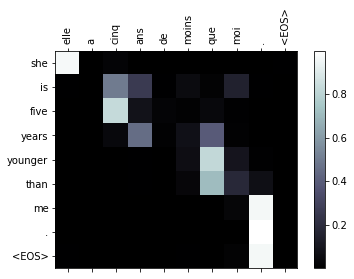

In [48]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

input = elle est trop petite .
output = she s too polite . <EOS>


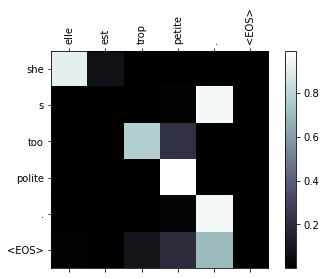

In [49]:
evaluateAndShowAttention("elle est trop petite .")

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


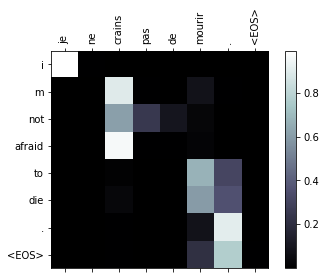

In [50]:
evaluateAndShowAttention("je ne crains pas de mourir .")

input = c est un jeune directeur plein de talent .
output = he is a very sensitive to cold . <EOS>


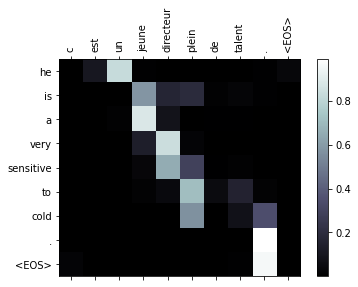

In [51]:
evaluateAndShowAttention("c est un jeune directeur plein de talent .")